In [1]:
# === colab configuration ===
# p.s. when training on colab, weights are saved on Drive (directory DSCAS/weights).
# p.p.s. skip this cell if running demo file locally!

! pip install torch-summary
! pip install ray
from google.colab import drive
import sys

# setting paths
repository_path = '/content/deep-seasonal-color-analysis-system/'
dataset_path = repository_path + 'headsegmentation_dataset_ccncsa/'
dataset_path_drive = '/content/drive/MyDrive/DSCAS/headsegmentation_dataset_ccncsa/'
weights_path = repository_path + 'models/weights/'
weights_path_drive = '/content/drive/MyDrive/DSCAS/weights/'
sys.path.insert(0, repository_path)

# cloning project repository and downloading dataset
drive.mount('/content/drive')
! test ! -d $repository_path && git clone https://github.com/mrcmich/deep-seasonal-color-analysis-system.git
! test ! -d $dataset_path && cp -R $dataset_path_drive $dataset_path
%cd $repository_path

# setting branch and pulling updates
branch = 'fastscnn_hyperparameters_tuning__refactoring'
! git checkout $branch
! git pull origin $branch

executing_on_colab = True

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.4/57.4 MB 14.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.8/8.8 MB 48.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 KB 29.0 MB/s eta 0:00:00
Mounted at /content/drive
Cloning into 'deep-seasonal-color-analysis-system'...
remote: Enumerating objects: 1094, done.
remote: Counting objects: 100% (575/575), done.
remote: Compressing objects: 100% (299/299), done.
remote: Total 1094 (delta 302), reused 456 (delta 274), pack-reused 519
Receiving objects: 100% (1094/1094), 270.74 MiB | 17.38 MiB/s, done.
Resolving deltas: 100% (621/621), done.
/content/deep-seasonal-color-analysis-system
Updating files: 100% (249/249), done.
Branch 'main__fastscnn_hyperparameters_tuning' set up to track remote branch 

In [2]:
import torch
from torch import nn
import torchvision.transforms as T
from sklearn.model_selection import train_test_split
from models import dataset, training_and_testing
from models.cloud.UNet import unet
from metrics_and_losses import metrics
from utils import segmentation_labels, utils
import matplotlib.pyplot as plt
from palette_classification import color_processing
import torchsummary
from models import config

try:
  executing_on_colab
except NameError:
  executing_on_colab = False
  weights_path = config.WEIGHTS_PATH
  dataset_path = config.DATASET_PATH

In [3]:
# defining transforms
tH, tW = 256, 256
image_transform = T.Compose([T.Resize((tH, tW)), T.Normalize(config.NORMALIZE_MEAN, config.NORMALIZE_STD)])
target_transform = T.Compose([T.Resize((tH, tW))])

# fetching dataset
n_classes = len(segmentation_labels.labels)
img_paths, label_paths = dataset.get_paths(dataset_path, file_name=config.DATASET_INDEX_NAME)
X_train, X_test, Y_train, Y_test = train_test_split(
    img_paths, label_paths, test_size=0.20, random_state=99, shuffle=True)
train_dataset = dataset.MyDataset(X_train, Y_train, image_transform, target_transform)
test_dataset = dataset.MyDataset(X_test, Y_test, image_transform, target_transform)

# training and test hyperparameters
batch_size = 32
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
# training hyperparameters
n_epochs = 50

# model, loss, score function
model_name = 'unet_ccncsa'
model = unet.UNet(out_channels=n_classes)
loss_fn = nn.CrossEntropyLoss()
score_fn = metrics.batch_mIoU

# optimizer
learning_rate = 0.01
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

model_summary = torchsummary.summary(model, input_data=(batch_size, 3, tH, tW), batch_dim=None, verbose=0)
print(model_summary)

Layer (type:depth-idx)                   Output Shape              Param #
├─Sequential: 1-1                        [32, 32, 256, 256]        --
|    └─Conv2d: 2-1                       [32, 32, 256, 256]        864
|    └─BatchNorm2d: 2-2                  [32, 32, 256, 256]        64
|    └─ReLU: 2-3                         [32, 32, 256, 256]        --
|    └─Conv2d: 2-4                       [32, 32, 256, 256]        9,216
|    └─BatchNorm2d: 2-5                  [32, 32, 256, 256]        64
|    └─ReLU: 2-6                         [32, 32, 256, 256]        --
├─MaxPool2d: 1-2                         [32, 32, 128, 128]        --
├─Sequential: 1-3                        [32, 64, 128, 128]        --
|    └─Conv2d: 2-7                       [32, 64, 128, 128]        18,432
|    └─BatchNorm2d: 2-8                  [32, 64, 128, 128]        128
|    └─ReLU: 2-9                         [32, 64, 128, 128]        --
|    └─Conv2d: 2-10                      [32, 64, 128, 128]        36,864
| 

In [ ]:
# training
results = training_and_testing.train_model(
    device, model, train_dataset, batch_size, n_epochs, score_fn, loss_fn, optimizer, 
    lr_scheduler=None, evaluate=True, verbose=True)

Device: cuda.
--- Epoch 1/50 ---
average_train_loss: 0.7019653023138345, average_train_score: 0.3621499538421631
average_val_loss: 0.5918622896784828, average_val_score: 0.36041274666786194
--- Epoch 2/50 ---
average_train_loss: 0.5538372372799789, average_train_score: 0.3703671991825104
average_val_loss: 0.5267815566252149, average_val_score: 0.36021363735198975
--- Epoch 3/50 ---
average_train_loss: 0.47008096034030966, average_train_score: 0.38363251090049744
average_val_loss: 0.4858631378128415, average_val_score: 0.3763314485549927
--- Epoch 4/50 ---
average_train_loss: 0.38492071029976904, average_train_score: 0.41373223066329956
average_val_loss: 0.48121674571718487, average_val_score: 0.38024643063545227
--- Epoch 5/50 ---
average_train_loss: 0.3085622539122899, average_train_score: 0.45686113834381104
average_val_loss: 0.35757376939531355, average_val_score: 0.45610788464546204
--- Epoch 6/50 ---
average_train_loss: 0.24808519908845256, average_train_score: 0.49830296635627747

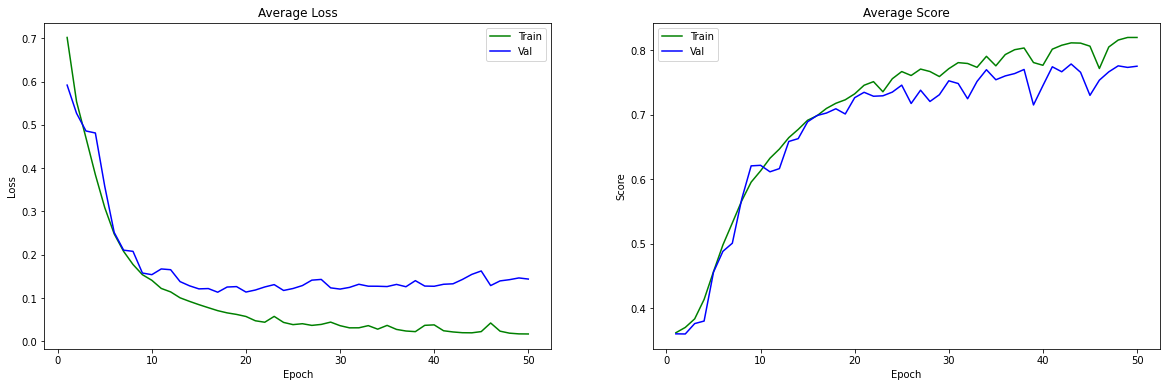

In [ ]:
# plotting training results
training_and_testing.plot_training_results(results, plotsize=(20, 6))

In [ ]:
# resetting model, optimizer, learning rate scheduler
final_model = unet.UNet(out_channels=n_classes)
final_optimizer = torch.optim.Adam(final_model.parameters(), lr=learning_rate)

# re-training model on entire training set and saving its weights
final_n_epochs = n_epochs // 2
training_and_testing.train_model(
    device, final_model, train_dataset, batch_size, final_n_epochs, score_fn, loss_fn, final_optimizer, verbose=True)
    
# saving final model's weights
torch.save(final_model.state_dict(), weights_path + model_name + '.pth')
if executing_on_colab is True:
  torch.save(final_model.state_dict(), weights_path_drive + model_name + '.pth')

Device: cuda.
--- Epoch 1/25 ---
average_train_loss: 0.6876009348374014, average_train_score: 0.3665767312049866
--- Epoch 2/25 ---
average_train_loss: 0.530929694597138, average_train_score: 0.38582029938697815
--- Epoch 3/25 ---
average_train_loss: 0.42665983018517206, average_train_score: 0.39916306734085083
--- Epoch 4/25 ---
average_train_loss: 0.33401623638865446, average_train_score: 0.42958322167396545
--- Epoch 5/25 ---
average_train_loss: 0.26397953000253394, average_train_score: 0.4723377823829651
--- Epoch 6/25 ---
average_train_loss: 0.21220412291135396, average_train_score: 0.5194709897041321
--- Epoch 7/25 ---
average_train_loss: 0.1777523599077945, average_train_score: 0.5668315291404724
--- Epoch 8/25 ---
average_train_loss: 0.15006674947014156, average_train_score: 0.6088640093803406
--- Epoch 9/25 ---
average_train_loss: 0.1322799589999074, average_train_score: 0.6314071416854858
--- Epoch 10/25 ---
average_train_loss: 0.116908155192258, average_train_score: 0.652851

In [5]:
# loading pretrained final model
try:
    final_model
except:
    final_model = unet.UNet(out_channels=n_classes)
    final_model.load_state_dict(torch.load(weights_path + model_name + '.pth'))

# testing model on test dataset
test_score_fn = metrics.batch_IoU
label_names = list(segmentation_labels.labels.keys())
class_weights = torch.tensor(config.CLASS_WEIGHTS, device=device)
batch_IoU = training_and_testing.test_model(device, final_model, test_dataset, batch_size, test_score_fn)
batch_IoU_with_labels = { label: score for label, score in list(zip(label_names, batch_IoU.tolist())) }
batch_mIoU = batch_IoU.mean().item()
batch_weighted_mIoU = utils.tensor_weighted_average(batch_IoU, class_weights).item()
for label in batch_IoU_with_labels:
    print(f'batch_IoU_{label}: {batch_IoU_with_labels[label]}')
print(f'batch_mIoU={batch_mIoU}')
print(f'batch_weighted_mIoU={batch_weighted_mIoU}')

Device: cuda.

Inference completed in around 51 seconds.
batch_IoU_background: 0.95879065990448
batch_IoU_lips: 0.6278900504112244
batch_IoU_eyes: 0.5608787536621094
batch_IoU_nose: 0.7773632407188416
batch_IoU_skin: 0.8749145865440369
batch_IoU_hair: 0.8085482716560364
batch_IoU_eyebrows: 0.5462294816970825
batch_IoU_ears: 0.725842297077179
batch_IoU_teeth: 0.7079448699951172
batch_IoU_beard: 0.8480401635169983
batch_IoU_sunglasses: 0.892117440700531
batch_mIoU=0.7571418285369873
batch_weighted_mIoU=0.7413017749786377


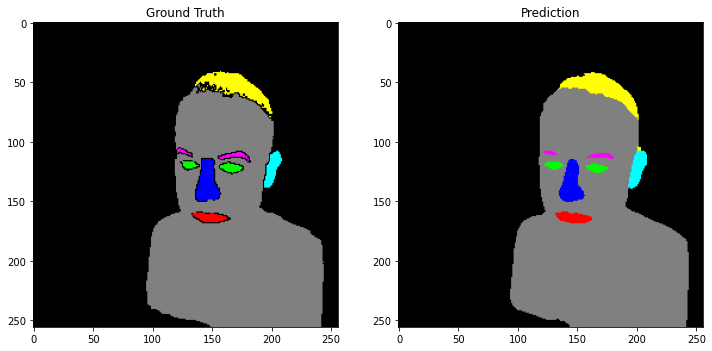

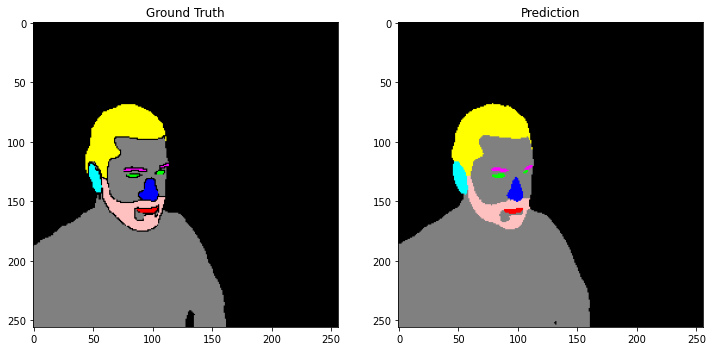

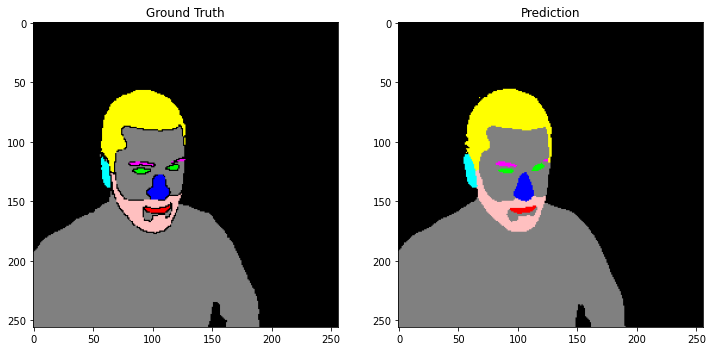

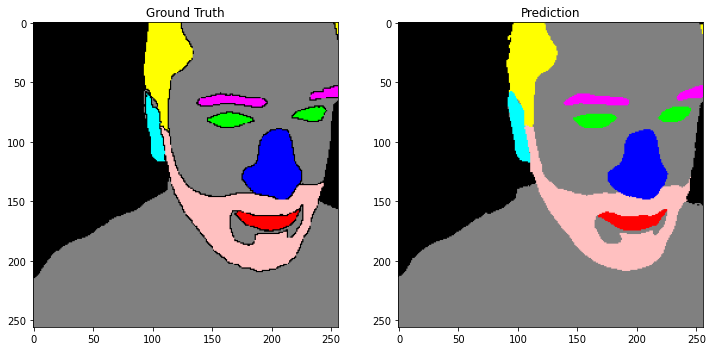

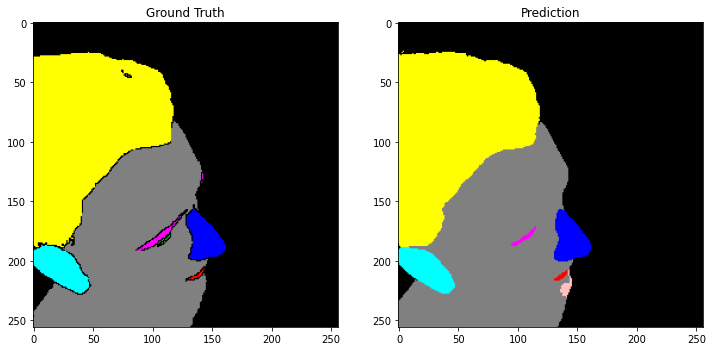

In [ ]:
# plotting some examples from test dataset
utils.plot_random_examples(device, final_model, test_dataset, n_examples=5)